# Imports

In [1]:
import sys
import os
sys.path.insert(0,'/Users/adam/Project/NIKA/Software/Processing/Labtools/RA/pitszi/')
import numpy as np
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.io import fits
import numpy as np
from astropy.wcs import WCS
from scipy.ndimage import gaussian_filter
from scipy.optimize import curve_fit
from reproject import reproject_interp

from minot.ClusterTools import map_tools
import pitszi

# Data and parameters

In [2]:
outdir = '/Users/adam/Desktop/MACSJ0717'
reso = 4*u.arcsec
FoV = 5*u.arcmin

In [3]:
# Cluster parameters
cls_name = 'MACSJ0717'
cls_redshift = 0.546
cls_M500 = 11.5
cls_coord = SkyCoord('07:17:31.654 +37:45:18.52', frame='icrs', unit=(u.hourangle, u.deg))

# Instrument parameters
beam_FWHM    = 18*u.arcsec
FoV_diameter = 2*u.arcmin

hdul = fits.open('/Users/adam/Project/Notes-Papier-Conf/2016_12_Edge_Search/Save/Products/TransferFunction150GHz_MACSJ0717.fits')
data_TF = hdul[1].data
TF_i = data_TF['TF'][0]
TF_i[np.isnan(TF_i)] = 1
TF = {'k':data_TF['WAVE_NUMBER_ARCSEC'][0]*u.arcsec**-1/2**0.5, 'TF':TF_i}

# Constants and usefull values
sigma2fwhm = 2 * np.sqrt(2*np.log(2))
y2jy = -11.6e3

# Analysis parameters
mask_theta = 1.5*u.arcmin

(0.0, 1.1)

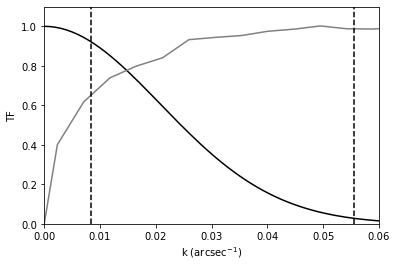

In [4]:
plt.plot(np.linspace(0, 1,1000), pitszi.utils_pk.beam_wf_pk(np.linspace(0, 1,1000), beam_FWHM.to_value('arcsec')), c='k')
plt.plot(TF['k'], TF['TF'], color='grey')
plt.xlabel('k (arcsec$^{-1}$)')
plt.ylabel('TF')
plt.axvline(1/beam_FWHM.to_value('arcsec'), c='k', ls='--')
plt.axvline(1/FoV_diameter.to_value('arcsec'), c='k', ls='--')
plt.xlim(0,0.06)
plt.ylim(0,1.1)

In [5]:
#===== Extract the data
# Data image
hdul = fits.open('/Users/adam/Project/Notes-Papier-Conf/2016_12_Edge_Search/Save/Products/MAP150GHz_'+cls_name+'.fits')
cls_head = map_tools.define_std_header(hdul[0].header['CRVAL1'], hdul[0].header['CRVAL2'],
                                       FoV.to_value('deg'), FoV.to_value('deg'), reso.to_value('deg'))
img_ini  = hdul[0].data /y2jy
img_ini, _ = reproject_interp((img_ini, hdul[0].header), cls_head)
img_ini[np.isnan(img_ini)] = 0

# Point source model
hdul = fits.open('/Users/adam/Project/Notes-Papier-Conf/2016_12_Edge_Search/Save/Products/PointSourceModel150GHz_'+cls_name+'.fits')
img_ps = hdul[0].data /y2jy
img_ps, _ = reproject_interp((img_ps, hdul[0].header), cls_head)
img_ps[np.isnan(img_ps)] = 0
cls_img = img_ini - img_ps
cls_ps = img_ps
    
# Noise
hdul = fits.open('/Users/adam/Project/Notes-Papier-Conf/2016_12_Edge_Search/Save/Products/NoiseMC150GHz_'+cls_name+'.fits')
noise = hdul[1].data/y2jy    
noise =  np.swapaxes(np.swapaxes(noise, 2,0), 1,2)
noise_rep = np.zeros((len(noise[:,0,0]), img_ini.shape[0], img_ini.shape[1]))
for imc in range(len(noise[:,0,0])):
    repro, _ = reproject_interp((noise[imc,:,:], hdul[0].header), cls_head)
    repro[np.isnan(repro)] = 0
    noise_rep[imc,:,:] = repro
cls_noise = noise_rep
cls_rms = np.std(noise_rep, axis=0)
cls_rms[cls_rms == 0] = np.amax(cls_rms)*1e5

# Define the model, data and inference

In [6]:
#========== cluster model
cls_model = pitszi.Model(name=cls_name, RA=cls_coord.ra, Dec=cls_coord.dec, 
                         redshift=cls_redshift, M500=cls_M500*1e14*u.Msun, 
                         silent=True, output_dir=outdir)
cls_model.set_pressure_profile_universal_param('A10UPP')
cls_model.model_pressure_fluctuation = {'name': 'CutoffPowerLaw',
                                        'Norm': 0.5, 
                                        'slope': -11/3.0,
                                        'Linj': 1*u.Mpc,
                                        'Ldis': 1*u.kpc}

cls_model.map_header = cls_head
cls_model.los_reso  = 100*u.kpc
cls_model.los_size  = 2*u.Mpc
cls_model.R_truncation = cls_model.R500*5

In [7]:
#========== cluster data
cls_data = pitszi.Data(cls_img, cls_head, silent=True, output_dir=outdir)
cls_data.psf_fwhm              = beam_FWHM
cls_data.transfer_function     = TF

#----- Define the noise properties
cls_data.noise_mc = cls_noise
cls_data.set_noise_model_from_mc()
cls_data.noise_mc = cls_data.get_noise_monte_carlo_from_model(Nmc=1000)
cls_data.noise_rms = cls_data.get_noise_rms_from_model(Nmc=1000)
cls_data.noise_rms[cls_data.noise_rms == 0] = np.amax(cls_data.noise_rms)*1e5

#----- Define the mask
rmss = gaussian_filter(cls_data.noise_rms, sigma=20/3600/sigma2fwhm/cls_head['CDELT2'])
mask = rmss * 0 + 1
cls_data.mask[rmss > 2*np.amin(rmss)] = 0

In [8]:
#========== Inference
cls_infer = pitszi.Inference(cls_data, cls_model, silent=False)
cls_infer.output_dir = outdir

cls_infer.kbin_min   = 1/FoV
cls_infer.kbin_max   = 1/(10*u.arcsec)
cls_infer.kbin_Nbin  = 8
cls_infer.kbin_scale = 'log'

cls_infer.method_parallel    = False
cls_infer.method_data_deconv = False

                        _  _    ___  ____ _                 
                  _ __ (_)| |_ / __||_  /(_)                
                 | '_ \| ||  _|\__ \ / / | |                
                 | .__/|_| \__||___//___||_|                
                 |_|                                        
   Probing ICM Turbulence from Sunyaev-Zel'dovich Imaging   
------------------------------------------------------------
                         Inference                          
------------------------------------------------------------


In [9]:
#========== Sampling information
cls_model.give_sampling_information()
print('kcounts:', cls_infer.get_kbin_counts())

===== Information relative to the grid sampling =====
   Grid size : 75 , 75 , 21
   Pixel size :      26.3     kpc ;     4.0      arcsec
   Fov size :  [   1973.8   ,   1973.8   ] kpc ; [   5.000    ,   5.000    ] arcmin
   L.o.S. resolution :        100.0     kpc
   Map center :   <SkyCoord (ICRS): (ra, dec) in deg
    (109.3875, 37.75416667)>
   k min/max projected :       0.003333  /  0.123333   1/arcsec
   k min/max projected :       0.000507  /  0.018746   1/kpc
   k min/max L.o.S. (eq.) :    0.003133  /  0.031330   1/arcsec
   k min/max L.o.S. :          0.000476  /  0.004762   1/kpc
   k max Nyquist :             0.031330   1/arcsec
   k max Nyquist :             0.004762   1/kpc
kcounts: [   8.   12.   16.   60.  124.  296.  684. 1620.]


# Fit the smooth model to the data

In [10]:
cls_infer.method_use_covmat  = False

#========== First run curvefit
RA = cls_infer.model.coord.ra
Dec = cls_infer.model.coord.dec

fitpar_prof = {
#'P_0': {'guess':[0.02, 0.001], 'unit': u.keV*u.cm**-3, 'limit':[0, np.inf]},
#'r_p': {'guess':[1000, 1000], 'unit': u.kpc, 'limit':[0, np.inf]},
#'a': {'guess':[1, 0.5], 'unit': None, 'limit':[0, 10]},
#'b': {'guess':[5, 0.5], 'unit': None, 'limit':[0, 10]},
#'c': {'guess':[0.5, 0.5], 'unit': None, 'limit':[-1, 3]},
'M500':{'guess':[10,1], 'unit':1e14*u.Msun, 'limit':[1, 100], 'P_ref':'A10MD'},
'RA': {'guess':[RA.to_value('arcmin'), 0.5], 'unit': u.arcmin, 'limit':[RA.to_value('arcmin')-0.5, RA.to_value('arcmin')+0.5]},
'Dec': {'guess':[Dec.to_value('arcmin'), 0.5], 'unit': u.arcmin, 'limit':[Dec.to_value('arcmin')-0.5, Dec.to_value('arcmin')+0.5]},
'min_to_maj_axis_ratio':{'guess':[1,0.1], 'unit':None, 'limit':[0,1]}, 
'angle':{'guess':[0,90], 'unit':u.deg, 'limit':[-90,90]},
'ZL':{'guess':[0,1e-5],'unit':None},
}
    
plist, popt, pcov = cls_infer.run_curvefit_profile(fitpar_prof, 
                                                   show_fit_result=True, 
                                                   set_bestfit=True)

#========== Then run MCMC
fitpar_prof = {
#'P_0': {'guess':[0.02, 0.001], 'unit': u.keV*u.cm**-3, 'limit':[0, np.inf]},
#'r_p': {'guess':[1000, 1000], 'unit': u.kpc, 'limit':[0, np.inf]},
#'a': {'guess':[1, 0.5], 'unit': None, 'limit':[0, 10]},
#'b': {'guess':[5, 0.5], 'unit': None, 'limit':[0, 10]},
#'c': {'guess':[0.5, 0.5], 'unit': None, 'limit':[-1, 3]},
'M500':{'guess':[popt[0],np.diag(pcov**0.5)[0]], 'unit':1e14*u.Msun, 'limit':[1, 100], 'P_ref':'A10MD'},
'RA': {'guess':[popt[1], np.diag(pcov**0.5)[1]], 'unit': u.arcmin, 'limit':[RA.to_value('arcmin')-0.5, RA.to_value('arcmin')+0.5]},
'Dec': {'guess':[popt[2], np.diag(pcov**0.5)[2]], 'unit': u.arcmin, 'limit':[Dec.to_value('arcmin')-0.5, Dec.to_value('arcmin')+0.5]},
'min_to_maj_axis_ratio':{'guess':[popt[3], np.diag(pcov**0.5)[3]], 'unit':None, 'limit':[0,1]}, 
'angle':{'guess':[popt[4], np.diag(pcov**0.5)[4]], 'unit':u.deg, 'limit':[-90,90]},
'ZL':{'guess':[popt[5], np.diag(pcov**0.5)[5]],'unit':None},
}

cls_infer.mcmc_nwalkers = 20
cls_infer.mcmc_nsteps   = 500
cls_infer.mcmc_burnin   = 0
cls_infer.mcmc_reset    = True
cls_infer.mcmc_run      = True
'''
plist, sampler = cls_infer.run_mcmc_profile(fitpar_prof,
                                            show_fit_result=True, 
                                            set_bestfit=True)
'''

param 0 (M500): 
   median   = 24.04183870488059 -0.8494595721203417 +0.8325414346490447
   best-fit = 24.0946620532712 -0.9022829205109524 +0.7797180862584341
   M500 = 24.04183870488059_{-0.8494595721203417}^{0.8325414346490447}
param 1 (RA): 
   median   = 6563.325121683205 -0.028053503829141846 +0.02799610752845183
   best-fit = 6563.33523892913 -0.03817074975449941 +0.017878861603094265
   RA = 6563.325121683205_{-0.028053503829141846}^{0.02799610752845183}
param 2 (Dec): 
   median   = 2265.2775851833917 -0.017332494855054392 +0.017237630178897234
   best-fit = 2265.246298084041 --0.01395460449566599 +0.048524729529617616
   Dec = 2265.2775851833917_{-0.017332494855054392}^{0.017237630178897234}
param 3 (min_to_maj_axis_ratio): 
   median   = 0.8161323788203589 -0.029882490486163427 +0.0298375346834181
   best-fit = 0.8138607552034223 -0.027610866869226758 +0.03210915830035477
   min_to_maj_axis_ratio = 0.8161323788203589_{-0.029882490486163427}^{0.0298375346834181}
param 4 (angl

/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in sqrt
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in sqrt
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in sqrt
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in sqrt
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in sqrt
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-pack

'\nplist, sampler = cls_infer.run_mcmc_profile(fitpar_prof,\n                                            show_fit_result=True, \n                                            set_bestfit=True)\n'

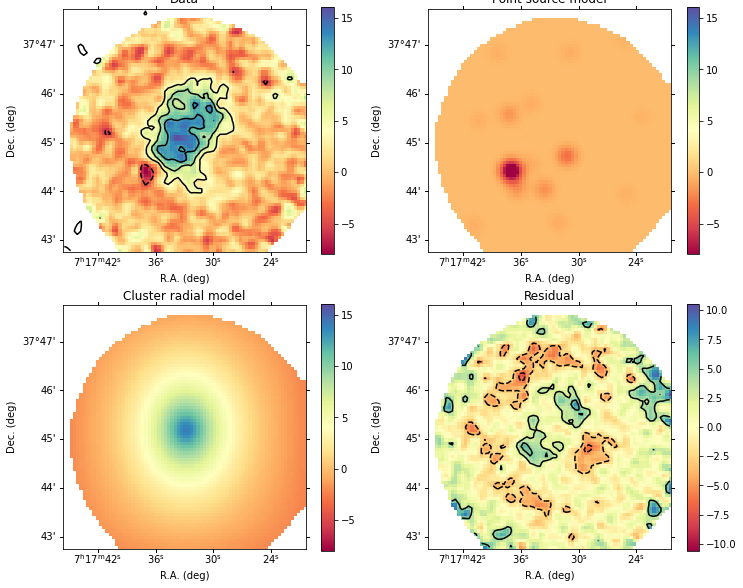

In [11]:
smooth_FWHM = 10*u.arcsec

# Show the data
plt.rcParams.update({'font.size': 10})
fig = plt.figure(0, figsize=(12, 10))
model_sph = cls_infer.get_radial_model()
    
rms = cls_data.get_noise_rms_from_model(Nmc=1000, smooth_fwhm=smooth_FWHM)
rms = gaussian_filter(rms, sigma=10/3600/sigma2fwhm/cls_head['CDELT2'])
    
rng = [np.nanmin(cls_data.mask*gaussian_filter(cls_img+cls_ps, sigma=smooth_FWHM.to_value('deg')/sigma2fwhm/cls_head['CDELT2'])*1e5),
       np.nanmax(cls_data.mask*gaussian_filter(cls_img+cls_ps, sigma=smooth_FWHM.to_value('deg')/sigma2fwhm/cls_head['CDELT2'])*1e5)]

msk = cls_data.mask
msk[cls_data.mask == 0] = np.nan
    
#----- Image
ax = plt.subplot(2, 2, 1, projection=WCS(cls_head))
plt.imshow(msk*gaussian_filter(cls_img+cls_ps, 
                               sigma=smooth_FWHM.to_value('deg')/sigma2fwhm/cls_head['CDELT2'])*1e5, 
           cmap='Spectral', vmin=rng[0], vmax=rng[1])
cb = plt.colorbar()
plt.contour(gaussian_filter(cls_img+cls_ps, 
                            sigma=smooth_FWHM.to_value('deg')/sigma2fwhm/cls_head['CDELT2'])/rms, 
            levels=[-6,-3,3,6,9,12,15,18,21], colors='k')
plt.title('Data')
plt.xlabel('R.A. (deg)')
plt.ylabel('Dec. (deg)')
    
#----- Point source model
ax = plt.subplot(2, 2, 2, projection=WCS(cls_head))
plt.imshow(msk*gaussian_filter(cls_ps, sigma=smooth_FWHM.to_value('deg')/sigma2fwhm/cls_head['CDELT2'])*1e5, 
           cmap='Spectral', vmin=rng[0], vmax=rng[1])
cb = plt.colorbar()
plt.title('Point source model')
plt.xlabel('R.A. (deg)')
plt.ylabel('Dec. (deg)')
    
#----- Cluster model
ax = plt.subplot(2, 2, 3, projection=WCS(cls_head))
plt.imshow(msk*gaussian_filter(model_sph, sigma=smooth_FWHM.to_value('deg')/sigma2fwhm/cls_head['CDELT2'])*1e5, 
           cmap='Spectral', vmin=rng[0], vmax=rng[1])
cb = plt.colorbar()
plt.title('Cluster radial model')
plt.xlabel('R.A. (deg)')
plt.ylabel('Dec. (deg)')
    
#----- Residual
rng = np.nanmax(msk*np.abs(gaussian_filter(cls_img-model_sph, sigma=smooth_FWHM.to_value('deg')/sigma2fwhm/cls_head['CDELT2'])*1e5))
ax = plt.subplot(2, 2, 4, projection=WCS(cls_head))
plt.imshow(msk*gaussian_filter(cls_img-model_sph, sigma=smooth_FWHM.to_value('deg')/sigma2fwhm/cls_head['CDELT2'])*1e5, 
           cmap='Spectral', vmin=-rng, vmax=rng)
cb = plt.colorbar()
plt.contour(msk*gaussian_filter(cls_img-model_sph, sigma=smooth_FWHM.to_value('deg')/sigma2fwhm/cls_head['CDELT2'])/rms, 
            levels=[-8,-6,-4,-2,2,4,6,8], colors='k')
plt.title('Residual')
plt.xlabel('R.A. (deg)')
plt.ylabel('Dec. (deg)')

In [12]:
# Parameters
cls_infer.method_use_covmat  = True
    
# Region of interest mask
ramap, decmap = map_tools.get_radec_map(cls_infer.data.header)
dist_map = map_tools.greatcircle(ramap, decmap, 
                                 cls_infer.model.coord.ra.to_value('deg'), 
                                 cls_infer.model.coord.dec.to_value('deg'))
roi_mask = dist_map * 0 + 1
roi_mask[dist_map > mask_theta.to_value('deg')] = 0 
    
# Weight definition
cls_infer.set_method_w8(roi_mask=roi_mask,
                        apply_data_mask=True,
                        apply_radial_model=True, 
                        conv_radial_model_beam=True, 
                        conv_radial_model_TF=False, 
                        remove_GNFW_core=True, 
                        smooth_FWHM=20*u.arcsec)
    
# Setup and save
cls_infer.pk_setup(Nmc=1000)
cls_infer.save_inference()

----- Running the setup -----
    * Setup imaging
    * Setup k binning
      - Counts in each k bin: [   8.   12.   16.   60.  124.  296.  684. 1620.]
      - Minimal count in k bins: 8.0
    * Setup Pk data, ref model and noise
    * Setup window function conversion
    * Setup bin-to-bin mixing
----- The setup is done -----


# Extract the 3d power spectrum

In [13]:
#========== First run curvefit
fitpar_pk3d = {
    'Norm':{'guess':[0.5, 0.5],'unit': None,'limit':[0, 3]}, #'prior':[0.5, 0.2],},
    #'slope':{'guess':[-11/3, 0.5],'unit': None,'limit':[-11/3-2, -11/3+2]}, #, #'prior':[-11/3, 0.5],},
    'Linj':{'guess':[800, 500],'unit': u.kpc,'limit':[100, 3000]}, #, 'prior':[600, 300],      
    'Anoise':{'guess':[1, 0.2],'unit': None,'limit':[0, 2]},
}

plist, popt, pcov = cls_infer.run_curvefit_fluctuation(fitpar_pk3d, show_fit_result=True)

#========== First run MCMC
fitpar_pk3d = {
    'Norm':{'guess':[popt[0],np.diag(pcov**0.5)[0]],'unit': None,'limit':[0, 3]}, #'prior':[0.5, 0.2],},
    #'slope':{'guess':[-11/3, 0.5],'unit': None,'limit':[-11/3-2, -11/3+2]}, #, #'prior':[-11/3, 0.5],},
    'Linj':{'guess':[popt[1],np.diag(pcov**0.5)[1]],'unit': u.kpc,'limit':[100, 3000]}, #, 'prior':[600, 300],      
    'Anoise':{'guess':[popt[2],np.diag(pcov**0.5)[2]],'unit': None,'limit':[0, 2]},
}

cls_infer.mcmc_nwalkers = 20
cls_infer.mcmc_nsteps   = 500
cls_infer.mcmc_burnin   = 0
cls_infer.mcmc_reset    = True
cls_infer.mcmc_run      = True
'''
plist, sampler = cls_infer.run_mcmc_fluctuation(fitpar_pk3d, 
                                                kind='projection', 
                                                show_fit_result=True,
                                                set_bestfit=True)
'''

----- Checking the Pk setup -----
      The setup was done. We can proceed, but still make sure that it was done with the correct analysis framework.
param 0 (Norm): 
   median   = 0.6978160015231456 -0.012772456899169615 +0.012765059872074436
   best-fit = 0.7078233931056497 -0.022779848481673692 +0.0027576682895703586
   Norm = 0.6978160015231456_{-0.012772456899169615}^{0.012765059872074436}
param 1 (Linj): 
   median   = 950.262481292755 -20.375642375296366 +19.961786971460924
   best-fit = 950.0415060443792 -20.15466712692057 +20.182762219836718
   Linj = 950.262481292755_{-20.375642375296366}^{19.961786971460924}
param 2 (Anoise): 
   median   = 1.1110702113863318 -0.049212236754207606 +0.049137870410668194
   best-fit = 1.0304130747880431 --0.03144489984408105 +0.12979500700895685
   Anoise = 1.1110702113863318_{-0.049212236754207606}^{0.049137870410668194}


/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in sqrt
  del sys.path[0]
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in sqrt
  from ipykernel import kernelapp as app
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in sqrt
  app.launch_new_instance()


"\nplist, sampler = cls_infer.run_mcmc_fluctuation(fitpar_pk3d, \n                                                kind='projection', \n                                                show_fit_result=True,\n                                                set_bestfit=True)\n"

# Derive the physical properties

In [14]:
from pitszi import physics_main

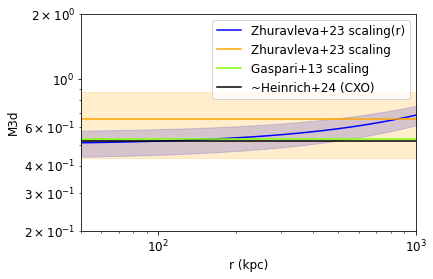

In [15]:
#===== Constraint on M3d
radius = np.logspace(np.log10(50),np.log10(2000))
M3d_r, M3d_r_err = physics_main.sigma_rad_to_M3d_Z23(popt[0], radius*u.kpc, cls_model.R500, state='unrelaxed', case='sum', ret_err=True)
plt.loglog(radius, M3d_r, color='blue', label='Zhuravleva+23 scaling(r)')
plt.fill_between(radius, M3d_r+M3d_r_err, M3d_r-M3d_r_err, alpha=0.2, color='blue')

plt.xlabel('r (kpc)')
plt.ylabel('M3d')
plt.xlim(50, 1000)
plt.ylim(0.2, 2)

M3d_r, M3d_r_err = physics_main.sigma_to_M3d_Z23(popt[0], state='unrelaxed', ell=True, ret_err=True)
plt.axhline(M3d_r, color='orange', label='Zhuravleva+23 scaling')
plt.fill_between(radius, radius*0+M3d_r+M3d_r_err, radius*0+M3d_r-M3d_r_err, 
                 alpha=0.2, color='orange')

k,pk = cls_infer.model.get_pressure_fluctuation_spectrum(1/cls_infer.model.model_pressure_fluctuation['Linj'])
Apeak = (np.sqrt(4*np.pi*k**3*pk)).to_value()[0]
M3d = physics_main.Apeak_to_M3d_G13(Apeak, Linj=cls_infer.model.model_pressure_fluctuation['Linj'])

plt.axhline(M3d, color='chartreuse', label='Gaspari+13 scaling')

plt.axhline(0.3*3**0.5, color='k', label='~Heinrich+24 (CXO)')
plt.legend()

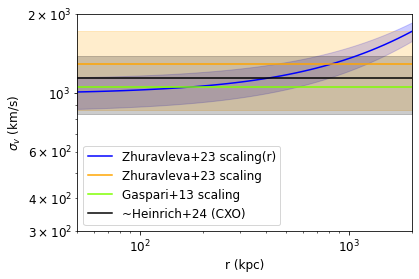

In [16]:
Tgas = 15*u.keV
cs = physics_main.sound_speed(Tgas).to_value('km/s')

#===== Constraint on sigma_v
M3d_r, M3d_r_err = physics_main.sigma_rad_to_M3d_Z23(popt[0], radius*u.kpc, cls_model.R500, state='unrelaxed', case='sum', ret_err=True)
plt.loglog(radius, cs*M3d_r, color='blue', label='Zhuravleva+23 scaling(r)')
plt.fill_between(radius, cs*M3d_r+cs*M3d_r_err, cs*M3d_r-cs*M3d_r_err, alpha=0.2, color='blue')

M3d_r, M3d_r_err = physics_main.sigma_to_M3d_Z23(popt[0], state='unrelaxed', ell=True, ret_err=True)
plt.axhline(cs*M3d_r, color='orange', label='Zhuravleva+23 scaling')
plt.fill_between(radius, radius*0+cs*M3d_r+cs*M3d_r_err, radius*0+cs*M3d_r-cs*M3d_r_err, 
                 alpha=0.2, color='orange')

k,pk = cls_infer.model.get_pressure_fluctuation_spectrum(1/cls_infer.model.model_pressure_fluctuation['Linj'])
Apeak = (np.sqrt(4*np.pi*k**3*pk)).to_value()[0]
M3d = physics_main.Apeak_to_M3d_G13(Apeak, Linj=cls_infer.model.model_pressure_fluctuation['Linj'])

plt.axhline(cs*M3d, color='chartreuse', label='Gaspari+13 scaling')

plt.axhline((575+749)/2*3**0.5, color='k', label='~Heinrich+24 (CXO)')
plt.fill_between(radius, radius*0+(575-95)*3**0.5, radius*0+(749+51)*3**0.5, 
                 alpha=0.2, color='k')

plt.xlabel('r (kpc)')
plt.ylabel(r'$\sigma_v$ (km/s)')
plt.xlim(50, 2000)
plt.ylim(300, 2000)
plt.legend()

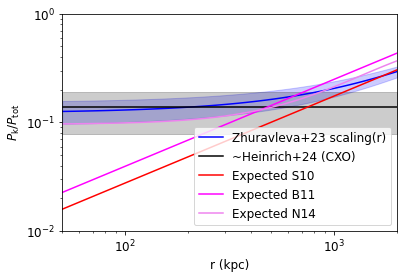

In [17]:
Tgas = 15*u.keV
cs = physics_main.sound_speed(Tgas).to_value('km/s')

#===== Constraint on Pk/Ptot
M3d_r, M3d_r_err = physics_main.sigma_rad_to_M3d_Z23(popt[0], radius*u.kpc, cls_model.R500, state='unrelaxed', case='sum', ret_err=True)

X = physics_main.Eturb_over_Etherm(M3d_r)
Prat = 1/(1+1/X)
X_u = physics_main.Eturb_over_Etherm(M3d_r+M3d_r_err)
Prat_u = 1/(1+1/X_u)
X_l = physics_main.Eturb_over_Etherm(M3d_r-M3d_r_err)
Prat_l = 1/(1+1/X_l)
plt.loglog(radius, Prat, color='blue', label='Zhuravleva+23 scaling(r)')
plt.fill_between(radius, radius*0+Prat_u, radius*0+Prat_l, 
                 alpha=0.2, color='blue')

plt.axhline((0.108+0.17)/2, color='k', label='~Heinrich+24 (CXO)')
plt.fill_between(radius, radius*0+(0.108-0.03), radius*0+(0.17+0.019), 
                 alpha=0.2, color='k')

plt.plot(radius, physics_main.pnt_over_ptot_r_S10(radius*u.kpc, cls_model.R500, cls_model.redshift), color='r', label='Expected S10')
plt.plot(radius, physics_main.pnt_over_ptot_r_B11(radius*u.kpc, cls_model.R500, cls_model.redshift), color='magenta', label='Expected B11')
plt.plot(radius, physics_main.pnt_over_ptot_r_N14(radius*u.kpc, cls_model.R500, cls_model.redshift), color='violet', label='Expected N14')

plt.xlabel('r (kpc)')
plt.ylabel(r'$P_{\rm k} / P_{\rm tot}$')
plt.xlim(50, 2000)
plt.ylim(0.01, 1)
plt.legend()